# Fake News Classification using Deep Learning

In this assignment, fake news classification has been performed using Long short-term memory (LSTM). 

The outcome of experimentation is as follows.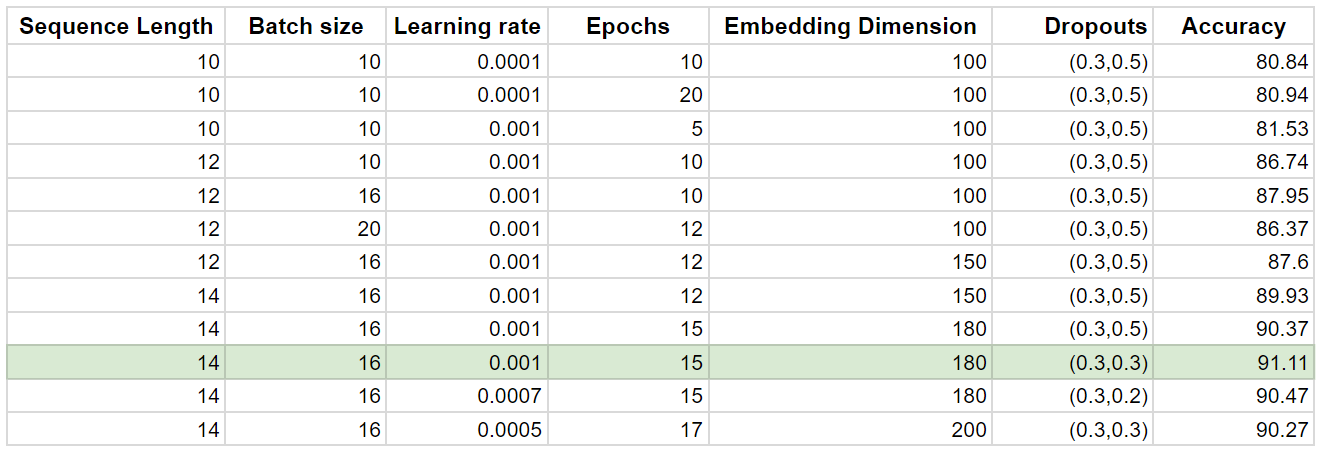

This accuracy is on the data in train.csv when it was splitted into 90:10 ratio. The accuracy on the data in test.csv as per Kaggle competition came out to be 47.11%.

**Please find the [flowchart](https://drive.google.com/file/d/19Sd7NJq0VGem9bLww_NnzSG1_nkXXbS-/view?usp=sharing) of this assignment.**

**Downloading the dataset**

In [ ]:
!gdown --id 1q0ZimHCtMlhftljfVuy0i-wcgPnDUYjl

Downloading...
From: https://drive.google.com/uc?id=1q0ZimHCtMlhftljfVuy0i-wcgPnDUYjl
To: /content/fake-news.zip
48.7MB [00:00, 73.3MB/s]


**Extracting the dataset**

In [ ]:
!unzip /content/fake-news.zip

Archive:  /content/fake-news.zip
  inflating: submit.csv              
  inflating: test.csv                
  inflating: train.csv               


**Importing the required packages and libraries**

In [ ]:
import numpy as np
import pandas as pd
from string import punctuation
from collections import Counter
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

**Storing the data in pandas dataframe**

In [ ]:
train_raw_data = pd.read_csv('/content/train.csv', encoding='utf-8', header=0, keep_default_na=False)

# Preprocessing on Data
In this section, preprocessing is performed on 'title' part of the data. Sentences of the title in each row are stored after removing punctuation and lowering the case of data. And then, words of all the sentences are stored separately.

In [ ]:
# Storing content of title from train_raw_data
train_data = train_raw_data['title']
# Making a list of sentences in title
sentences = [''.join([sym for sym in data.lower() if sym not in punctuation]) for data in train_data]
# Creating a list of words
words = []
for sent in sentences:
  for word in sent.split():
    words.append(word)

In [ ]:
print("Total number of sentences in training data:", len(sentences))
print("The first sentence is:", sentences[0])
print("The total number of words in training data:", len(words))
print("Words of 1st sentence:", words[0:14])

Total number of sentences in training data: 20800
The first sentence is: house dem aide we didn’t even see comey’s letter until jason chaffetz tweeted it
The total number of words in training data: 241368
Words of 1st sentence: ['house', 'dem', 'aide', 'we', 'didn’t', 'even', 'see', 'comey’s', 'letter', 'until', 'jason', 'chaffetz', 'tweeted', 'it']


# Encoding of the data

In this section, dictionary is formed which contrains (word, encoding) pairs. Then, encoding ints of sentences that are non-zero are stored sentence-wise in variable name encoded_sents. encoded_labels simply contains labels of the corresponding sentences.

In [ ]:
# freq stores the word:frequency pair
freq = Counter(words)
# vocabulary stores the words as per frequency in descending order
vocabulary = sorted(freq, key=freq.get, reverse=True)
# vocab_to_int assigns integer to words in sequence
vocab_to_int = {word: i for i, word in enumerate(vocabulary, 1)}

# Storing the tokenized texts in encoded_sents 
encoded_sents = []
encoded_labels = []
labels = train_raw_data['label']
for i in range(len(sentences)):
  if len(sentences[i]) != 0:
    encoded_sents.append([vocab_to_int[word] for word in sentences[i].split()])
    encoded_labels.append(labels[i])

encoded_sents = np.array(encoded_sents)
encoded_labels = np.array(encoded_labels)

In [ ]:
print("Total number of non-zero sentences is:", len(encoded_sents))

Total number of non-zero sentences is: 20242


# Padding of sentences
Padding has been performed in order to deal with shorter and longer sentences. For shorter sentences, 0s have been padded before the sentence encoding. And for longer sentences, the encoding ints have been truncated.

'Padded_data' is a 2D array with number of rows equal to number of sentences and number of columns equal to 'length'

In [ ]:
length = 14
padded_data = np.zeros((len(encoded_sents), length), dtype=int)
ind = 0
for sent in encoded_sents:
  padded_data[ind, -len(sent):] = sent[:length]
  ind = ind + 1

In [ ]:
print("First 4 sentences before padding:\n", 
      "Length:", len(encoded_sents[0]), "-->", encoded_sents[0],"\n",
      "Length:", len(encoded_sents[1]), "-->", encoded_sents[1],"\n", 
      "Length:", len(encoded_sents[2]), "-->", encoded_sents[2],"\n", 
      "Length:", len(encoded_sents[3]), "-->", encoded_sents[3],)
print("=========================================================================================")
print("First 4 sentences after padding with word-length:",length,"\n", padded_data[:4])

First 4 sentences before padding:
 Length: 14 --> [67, 599, 1016, 76, 571, 293, 269, 1173, 572, 1058, 1683, 3094, 8776, 34] 
 Length: 8 --> [851, 16, 19, 145, 178, 13, 1271, 12] 
 Length: 7 --> [54, 1, 399, 836, 106, 40, 806] 
 Length: 10 --> [693, 562, 166, 6, 1604, 20, 2012, 50, 263, 4805]
First 4 sentences after padding with word-length: 14 
 [[  67  599 1016   76  571  293  269 1173  572 1058 1683 3094 8776   34]
 [   0    0    0    0    0    0  851   16   19  145  178   13 1271   12]
 [   0    0    0    0    0    0    0   54    1  399  836  106   40  806]
 [   0    0    0    0  693  562  166    6 1604   20 2012   50  263 4805]]


# Splitting the dataset 
Splitting the data into training and test data with 90:10 ratio using sklearn train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, encoded_labels, test_size=0.10, random_state=42)

# Batching and DataLoaders
Creating tensor objects and storing them in batches. 

In [ ]:
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size= 16, shuffle=True)

# Defining the model

In this section, the model named NewsClassifier is defined. The layers are as follows
1.   The embedding layer for converting encoding ints to embeddings of size embedding_dim
2.   The LSTM layer that contains number of layers within itself
3.   The fully connected layer that maps the LSTM layer outputs to the required output_size, 1 in our case.
2.   Sigmoid activation for turning outputs into 0-1





In [ ]:
class NewsClassifier(nn.Module):

  def __init__(self):
    # Initializing the model by setting up the layers
    super(NewsClassifier, self).__init__()
    
    self.embedding = nn.Embedding(len(vocab_to_int)+1, 180)
    self.lstm = nn.LSTM(180, 256, 3, dropout=0.3, batch_first=True)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(256, 1)
    self.sig = nn.Sigmoid()

  def forward(self, x):
    # Performing a forward pass of our model
    batch_size = x.size(0)
    x = self.embedding(x)
    x, temp = self.lstm(x)
    x = x.contiguous().view(-1, 256)
    x = self.dropout(x)
    x = self.fc(x)
    x = self.sig(x)
    x = x.view(batch_size, -1)
    x = x[:, -1] 

    return x

# Instantiate the network

In [ ]:
model = NewsClassifier()
print(model)

NewsClassifier(
  (embedding): Embedding(29337, 180)
  (lstm): LSTM(180, 256, num_layers=3, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# loss and optimization functions

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

Training on the model defined above is performed with epochs that iterate through the training dataset and clip for the maximum gradiet value.

In [ ]:
epochs = 15
clip = 5  

# Training for the number of epochs
for e in range(epochs):
  # Keeping track of training and validation loss
  train_loss = 0.0
  num_correct = 0

  model.train()
  # batch loop
  for inputs, labels in train_loader:
    # zero accumulated gradients
    model.zero_grad()
    # getting the output from the model
    output = model(inputs)
    # calculating the loss and performing backpropagation 
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    # 'clip_grad_norm' helps prevent the exploding gradient problem in RNNs / LSTMs.
    nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    # updating training loss
    train_loss = train_loss + loss.item()*inputs.size(0)

  train_loss = train_loss/len(train_loader.dataset)

  print("Epoch: {}/{}...".format(e + 1, epochs),
        "Loss: {:.6f}...".format(train_loss))

Epoch: 1/15... Loss: 0.277872...
Epoch: 2/15... Loss: 0.163335...
Epoch: 3/15... Loss: 0.076733...
Epoch: 4/15... Loss: 0.033753...
Epoch: 5/15... Loss: 0.017603...
Epoch: 6/15... Loss: 0.012973...
Epoch: 7/15... Loss: 0.009555...
Epoch: 8/15... Loss: 0.008421...
Epoch: 9/15... Loss: 0.005323...
Epoch: 10/15... Loss: 0.004651...
Epoch: 11/15... Loss: 0.003278...
Epoch: 12/15... Loss: 0.001628...
Epoch: 13/15... Loss: 0.005883...
Epoch: 14/15... Loss: 0.003762...
Epoch: 15/15... Loss: 0.002967...


# Getting test data loss and accuracy


In [ ]:
test_losses = [] # track loss
num_correct = 0

model.eval()

# Iterating over test data
for inputs, labels in test_loader:
  # zero accumulated gradients
  model.zero_grad()
  # getting predicted outputs
  output = model(inputs)
  # calculating loss
  test_loss = criterion(output.squeeze(), labels.float())
  test_losses.append(test_loss.item())
  
  # converting output probabilities to predicted class (0 or 1)
  pred = torch.round(output.squeeze())
  
  # comparing predictions to true label
  correct_tensor = pred.eq(labels.float().view_as(pred))
  correct = np.squeeze(correct_tensor.numpy())
  num_correct = num_correct + np.sum(correct)

print("Test loss: {:.6f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.2f}%".format(test_acc*100))

Test loss: 0.553440
Test accuracy: 91.11%



------------------------------------------------------------------------------

# Prediction on the data in test.csv

This section repeats the process done in training phase, but In test phase, we don't need to compute gradients. So this, section predicts the labels and updates them in submit.csv

The test accuracy as per Kaggle came out to be 47.11%


In [ ]:
test_raw_data = pd.read_csv('/content/test.csv', encoding='utf-8', header=0, keep_default_na=False)
# Storing content of title from train_raw_data
test_data = test_raw_data['title']
# Making a list of sentences in title
sentences = [''.join([sym for sym in data.lower() if sym not in punctuation]) for data in test_data]
# Creating a list of words
words = []
for sent in sentences:
  for word in sent.split():
    words.append(word)

In [ ]:
# storing the tokenized texts in encoded_sents 
encoded_sents = []
for i in range(len(sentences)):
  if len(sentences[i]) != 0:
    encoded_sents.append([vocab_to_int[word] if word in vocab_to_int else 0 for word in sentences[i]])
  if len(sentences[i]) == 0:
    encoded_sents.append([0]*14)

encoded_sents = np.array(encoded_sents)

In [ ]:
length = 14
padded_data = np.zeros((len(encoded_sents), length), dtype=int)
ind = 0
for sent in encoded_sents:
  padded_data[ind, -len(sent):] = sent[:length]
  ind = ind + 1

In [ ]:
preds = []

model.eval()
# converting to tensor to pass into your model
padded_data_tensor = torch.from_numpy(padded_data)
test_loader = DataLoader(padded_data_tensor, batch_size = 1, shuffle=True)
# iterating over test data
for inputs in test_loader:
  model.zero_grad()
  output = model(inputs)
  preds.append(int(torch.round(output.squeeze())))

# Storing the labels to submit.csv file

The [link](https://drive.google.com/file/d/1NJYfxRFx4OCDUkhzdaoemEfb_FN3Mx1f/view?usp=sharing) for submit.csv file with generated labels.

In [ ]:
import csv

with open('submit.csv', 'w') as f:
  f_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

  f_writer.writerow(['id', 'label'])
  for i in range(len(preds)):
      f_writer.writerow([test_raw_data['id'][i], preds[i]])

In [ ]:
submit_data = pd.read_csv('submit.csv', encoding='utf-8', header=0, keep_default_na=False)
submit_data

,id,label
0,20800,1
1,20801,1
2,20802,1
3,20803,1
4,20804,1
...,...,...
5195,25995,1
5196,25996,1
5197,25997,1
5198,25998,1
